# Очередной тест для моего диплома

In [2]:
%pip install openneuro-py mne mne_bids --quiet

Note: you may need to restart the kernel to use updated packages.


## Загрузка датасета для конкретного пациента (с БП), EDA

In [3]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openneuro
import mne
from mne.viz import plot_topomap
from mne.datasets import sample
from mne import Epochs
from mne.decoding import SSD

from mne_bids import (
    BIDSPath,
    find_matching_paths,
    get_entity_vals,
    make_report,
    print_dir_tree,
    read_raw_bids,
)
import naplib as nl
from naplib.io import load_bids

/opt/anaconda3/envs/conda_mne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# .. note: If the keyword argument include is left out of
#          ``openneuro.download``, the whole dataset will be downloaded.
#          We're just using data from one subject to reduce the time
#          it takes to run the example.

dataset = "ds002778"
subject_pd = "pd6" # subject with PD
subject_hc = "hc7" # healthy subject

# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset)
if not op.isdir(bids_root):
    os.makedirs(bids_root)

openneuro.download(dataset=dataset, target_dir=bids_root, include=[f"sub-{subject_pd}", f"sub-{subject_hc}"])


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …


📁 Traversing directories for ds002778 : 27 entities [00:11,  2.33 entities/s]

📥 Retrieving up to 26 files (5 concurrent downloads). 
✅ Finished downloading ds002778.
 
🧠 Please enjoy your brains.
 


In [5]:
print_dir_tree(bids_root, max_depth=4)

|ds002778/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-hc7/
|------ ses-hc/
|--------- sub-hc7_ses-hc_scans.tsv
|--------- beh/
|------------ sub-hc7_ses-hc_task-rest_beh.json
|------------ sub-hc7_ses-hc_task-rest_beh.tsv
|--------- eeg/
|------------ sub-hc7_ses-hc_task-rest_channels.tsv
|------------ sub-hc7_ses-hc_task-rest_eeg.bdf
|------------ sub-hc7_ses-hc_task-rest_eeg.json
|------------ sub-hc7_ses-hc_task-rest_events.tsv
|--- sub-pd6/
|------ ses-off/
|--------- .DS_Store
|--------- sub-pd6_ses-off_scans.tsv
|--------- beh/
|------------ sub-pd6_ses-off_task-rest_beh.json
|------------ sub-pd6_ses-off_task-rest_beh.tsv
|--------- eeg/
|------------ sub-pd6_ses-off_task-rest_channels.tsv
|------------ sub-pd6_ses-off_task-rest_eeg.bdf
|------------ sub-pd6_ses-off_task-rest_eeg.json
|------------ sub-pd6_ses-off_task-rest_events.tsv
|------ ses-on/
|--------- sub-pd6_ses-on_scans.tsv
|--------- beh/
|-----------

In [6]:
print(make_report(bids_root))

Summarizing participants.tsv /Users/evakhromeeva/mne_data/ds002778/participants.tsv...
Summarizing scans.tsv files [PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/sub-hc7_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-on/sub-pd6_ses-on_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/sub-pd6_ses-off_scans.tsv')]...
The participant template found: comprised of 14 male and 17 female participants;
comprised of 31 right hand, 0 left hand and 0 ambidextrous;
ages ranged from 47.0 to 82.0 (mean = 63.39, std = 8.69)
 The UC San Diego Resting State EEG Data from Patients with Parkinson's Disease
dataset was created by Alexander P. Rockhill, Nicko Jackson, Jobi George, Adam
Aron, and Nicole C. Swann and conforms to BIDS version 1.2.2. This report was
generated with MNE-BIDS (https://doi.org/10.21105/joss.01896). The dataset
consists of 2 participants (comprised of 14 male and 17 female participants;
comprised of 31 

In [7]:
sessions = get_entity_vals(bids_root, "session", ignore_sessions="on")
datatype = "eeg"
extensions = [".bdf", ".tsv"]  # ignore .json files
bids_paths = find_matching_paths(
    bids_root, datatypes=datatype, sessions=sessions, extensions=extensions
)

In [8]:
print(bids_paths)

[BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc7_ses-hc_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc7_ses-hc_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc7_ses-hc_task-rest_events.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_events.tsv)]


In [9]:
session = "off"
bids_path = BIDSPath(root=bids_root, session=session, datatype=datatype)
print(bids_path.match(ignore_json=True))

[BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_events.tsv)]


## Чтение данных

In [10]:
task = "rest"
suffix = "eeg"

bids_path_pd = bids_path.update(subject=subject_pd, task=task, suffix=suffix)

In [11]:
print(bids_path_pd)

/Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf


In [12]:
bids_path_pd

BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd6_ses-off_task-rest_eeg)

In [13]:
raw_pd = read_raw_bids(bids_path=bids_path_pd, verbose=False)

/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_40730/3169525109.py:1: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 42
disease_duration: 8
rl_deficits: L OFF meds, more R ON meds
notes: Used preprocessed data from EEGLAB .mat file instead of raw data for pd on
  raw_pd = read_raw_bids(bids_path=bids_path_pd, verbose=False)


In [14]:
print(raw_pd.info["subject_info"])

{'his_id': 'sub-pd6', 'birthday': datetime.date(1949, 2, 17), 'hand': 1}


In [15]:
print(raw_pd.info["line_freq"])

60.0


In [16]:
print(raw_pd.info["sfreq"])

512.0


In [17]:
print(raw_pd.annotations)

<Annotations | 2 segments: 1 (1), 65536 (1)>


Using matplotlib as 2D backend.


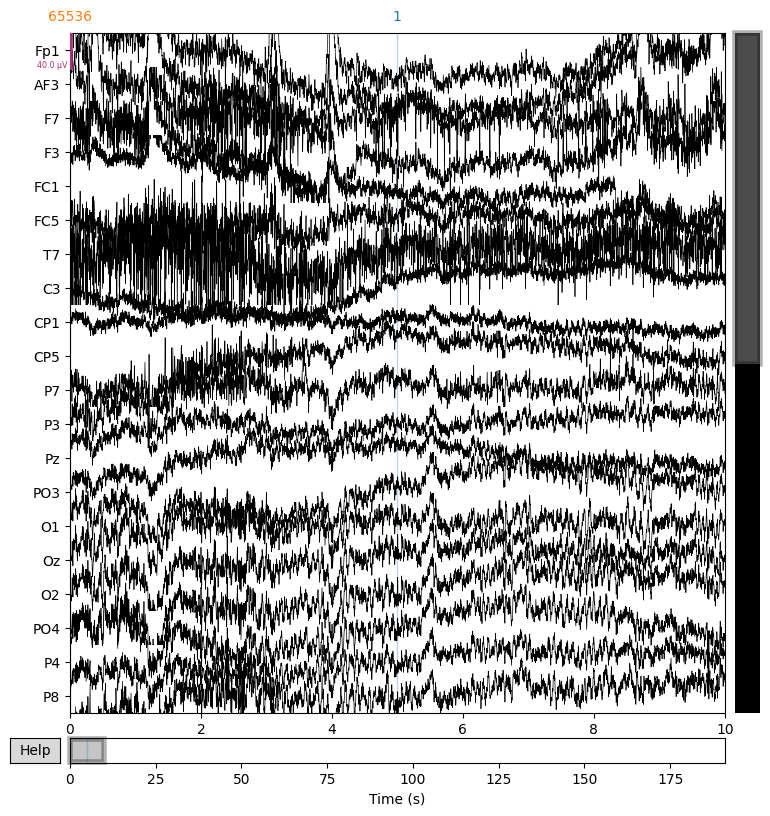

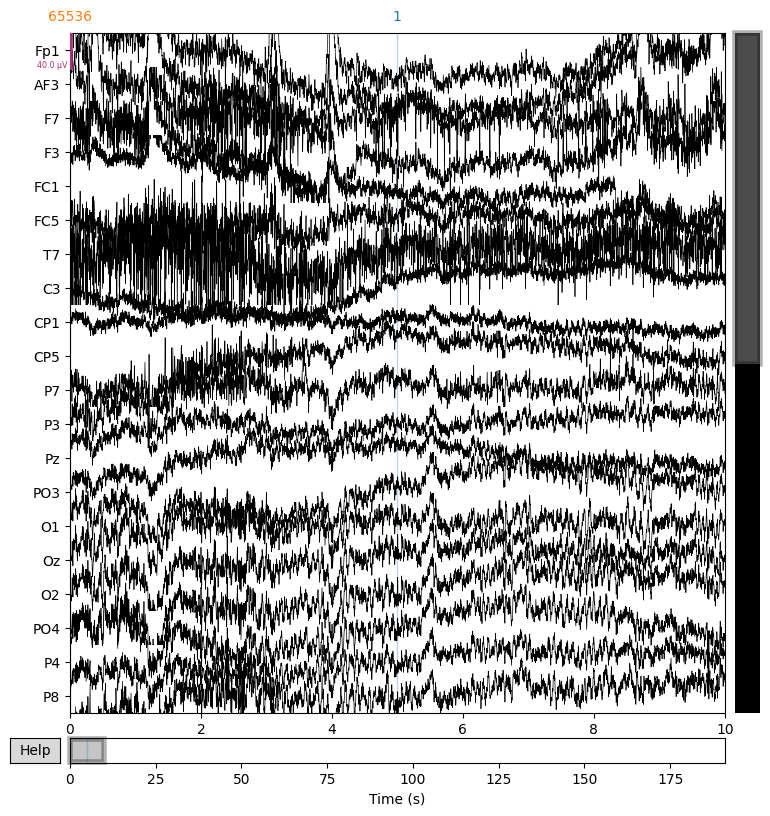

In [18]:
raw_pd.plot()

In [19]:
# We are only interested in the 32-channel EEG data as the responses, so select those channels
resp_channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7',
                 'P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2',
                 'C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

data_pd = load_bids(root=bids_root, subject=subject_pd, datatype='eeg', task='rest', suffix='eeg', session='off', resp_channels=resp_channels)
data_hc = load_bids(root=bids_root, subject=subject_hc, datatype='eeg', task='rest', suffix='eeg', session='hc', resp_channels=resp_channels)

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_events.tsv.
Reading channel info from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/opt/anaconda3/envs/conda_mne/lib/python3.11/site-packages/naplib/io/load_bids.py:94: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 30
NAART: 42
disease_duration: 8
rl_deficits: L OFF meds, more R ON meds
notes: Used preprocessed data from EEGLAB .mat file instead of raw data for pd on
  raw = read_raw_bids(bids_path=bids_path)
100%|██████████| 2/2 [00:00<00:00, 32.63it/s]

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_events.tsv.
Reading channel info from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).



/opt/anaconda3/envs/conda_mne/lib/python3.11/site-packages/naplib/io/load_bids.py:94: RuntimeWarning: Unable to map the following column(s) to to MNE:
gender: f
MMSE: 26
NAART: 48
disease_duration: n/a
rl_deficits: n/a
notes: n/a
  raw = read_raw_bids(bids_path=bids_path)
100%|██████████| 2/2 [00:00<00:00, 32.04it/s]


In [20]:
data_pd.mne_info

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 10:07:18 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 3 items (dict)
>

In [21]:
data_pd[0]

{'event_index': 0,
 'description': '65536',
 'stim': array([[6.5536e+04],
        [6.5536e+04],
        [6.5536e+04],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00]]),
 'stim_ch_names': ['Status'],
 'resp': array([[ 0.00500388,  0.00073836, -0.00068723, ...,  0.00412316,
          0.0082125 ,  0.00490838],
        [ 0.00500866,  0.00073611, -0.00069192, ...,  0.0041221 ,
          0.00821081,  0.00490738],
        [ 0.00501576,  0.0007387 , -0.0006913 , ...,  0.0041226 ,
          0.00820916,  0.00490494],
        ...,
        [ 0.0049516 ,  0.00069064, -0.00069389, ...,  0.00401407,
          0.00817834,  0.00491629],
        [ 0.00495354,  0.00069808, -0.00071942, ...,  0.00401329,
          0.00817869,  0.00491457],
        [ 0.00494716,  0.00069461, -0.00070064, ...,  0.00400785,
          0.00817428,  0.00490926]]),
 'befaft': [0, 0],
 'sfreq': 512.0,
 'ch_names': ['Fp1',
  'AF3',
  'F7',
  'F3',
  'FC1',
  'FC5',
  'T7',
  'C3',
  'CP1',
  'CP5',
  

## Рассчитаем соотношение альфа и тета ритмов:
Спектральная плотность мощности (PSD, СПМ) в физике и обработке сигналов — функция, описывающая распределение мощности сигнала в зависимости от частоты, то есть мощность, приходящуюся на единичный интервал частоты.

Имеет размерность мощности, делённой на частоту, то есть энергии. Например, в Международной системе единиц (СИ) это Вт/с−1 (Вт·с) или Вт/Гц. 1

Часто термин применяется при описании спектральной мощности потоков электромагнитного излучения или других колебаний в сплошной среде, например, акустических. 1 В этом случае подразумевается мощность на единицу частоты на единицу площади, например: Вт·Гц-1·м-2, часто также Дж·м-2.

In [22]:
def log_alpha_theta_ratio(response, sfreq):
    '''response should be of shape (time * channels)'''
    # must transpose response for mne function
    alpha_psd, _ = mne.time_frequency.psd_array_welch(response.T, sfreq, fmin=8, fmax=13, verbose=False) # psd is shape (channels * freqs)
    alpha_psd = alpha_psd.mean(-1)
    
    theta_psd, _ = mne.time_frequency.psd_array_welch(response.T, sfreq, fmin=4, fmax=8, verbose=False) # psd is shape (channels * freqs)
    theta_psd = theta_psd.mean(-1)
    #print(f'{np.mean(np.log(alpha_psd))} {np.mean(np.log(theta_psd))}')
    
    return np.log(alpha_psd / theta_psd)
    

alpha_theta_ratio_pd = [log_alpha_theta_ratio(trial['resp'], trial['sfreq']) for trial in data_pd]
alpha_theta_ratio_hc = [log_alpha_theta_ratio(trial['resp'], trial['sfreq']) for trial in data_hc]

In [23]:
df_pd = pd.DataFrame(alpha_theta_ratio_pd)
df_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-2.956091,-2.605477,-1.532497,-1.992585,-0.979684,-0.410979,-0.368561,-0.265077,-0.648261,-0.838916,...,0.450846,-0.111134,-0.305652,-0.414599,-1.810505,-1.664818,-2.619720,-2.810747,-1.821417,0.003271
1,-2.312230,-1.803975,-0.641801,-1.113163,-0.459126,-0.309230,-0.220693,-0.387382,0.209164,0.043153,...,0.204603,0.088299,-0.008959,-0.143371,-1.007491,-0.769636,-1.793098,-2.209526,-0.891412,-0.197601


In [24]:
df_hc = pd.DataFrame(alpha_theta_ratio_hc)
df_hc.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-2.158081,-1.557962,-0.635515,-1.015756,-1.099973,-0.468332,-0.263327,-0.471416,-0.368454,-0.166000,...,-0.624862,0.246523,-0.568634,-0.706732,-1.518856,-0.959792,-2.034258,-2.294857,-1.449469,-0.340760
1,-1.140596,-0.614844,-0.020063,-0.351466,-0.184199,0.099997,0.488001,0.052781,0.176115,0.355984,...,0.122959,0.305460,0.087407,-0.128352,-0.295869,-0.035138,-0.590576,-1.042259,-0.334008,-0.161981


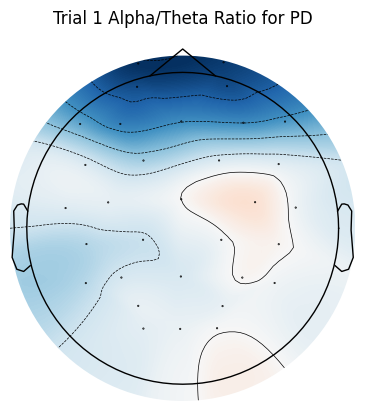

In [25]:
# First, we need to set the montage (i.e. the arrangement of electrodes) so that the channels can be plotted properly
# Here, we set it to the standard 10-20 system, but many options are available if the data were recorded in a different
# montage. See https://mne.tools/dev/generated/mne.channels.make_standard_montage.html for details
data_pd.mne_info.set_montage('standard_1020')

fig, ax = plt.subplots()
ax.set_title('Trial 1 Alpha/Theta Ratio for PD')
plot_topomap(alpha_theta_ratio_pd[0], data_pd.mne_info, axes=ax)
plt.show()

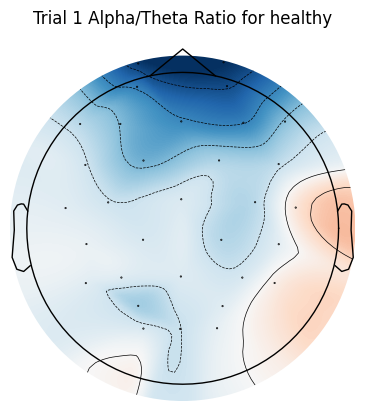

In [26]:
data_hc.mne_info.set_montage('standard_1020')
fig, ax = plt.subplots()
ax.set_title('Trial 1 Alpha/Theta Ratio for healthy')
plot_topomap(alpha_theta_ratio_hc[0], data_hc.mne_info, axes=ax)
plt.show()

## Попытка соединить в единый датасет

In [28]:
#epochs = Epochs(raw, events, tmin=0.0, tmax=5, baseline=None, preload=True)

In [29]:
%pip install autoreject --quiet

Note: you may need to restart the kernel to use updated packages.


In [30]:
from autoreject import AutoReject
from autoreject import get_rejection_threshold

subject_hc = 'hc7'

raw_hc = mne.io.read_raw_bdf('/Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf', preload=True)
raw_hc.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8',
                                  'Status']) #drop extra channels
raw_hc.set_eeg_reference(ref_channels='average')
raw_hc.filter(0.5, None, fir_design='firwin',phase='zero-double') #remove drifts

epochs_hc = mne.make_fixed_length_epochs(raw_hc, duration=1.0, preload=False, proj=True)
reject = get_rejection_threshold(epochs_hc)
print('The rejection dictionary is %s' % reject)
epochs_hc.drop_bad(reject=reject)

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)

Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


The rejection dictionary is {'eeg': 0.00010340581484039486}
Using data from preloaded Raw for 192 events and 512 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'FC6', 'F8', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'T8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'T8', 'Fp2']
    Rejecting  epoch based 

<Epochs | 154 events (all good), 0 – 0.998 s (baseline off), ~29 kB, data not loaded,
 '1': 154>

Using data from preloaded Raw for 1 events and 512 original time points ...


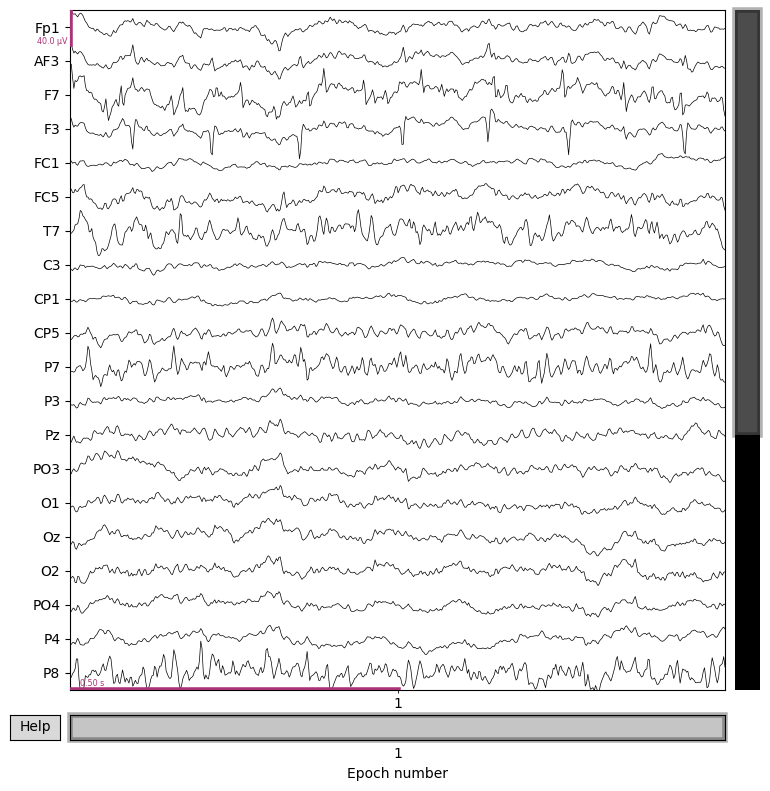

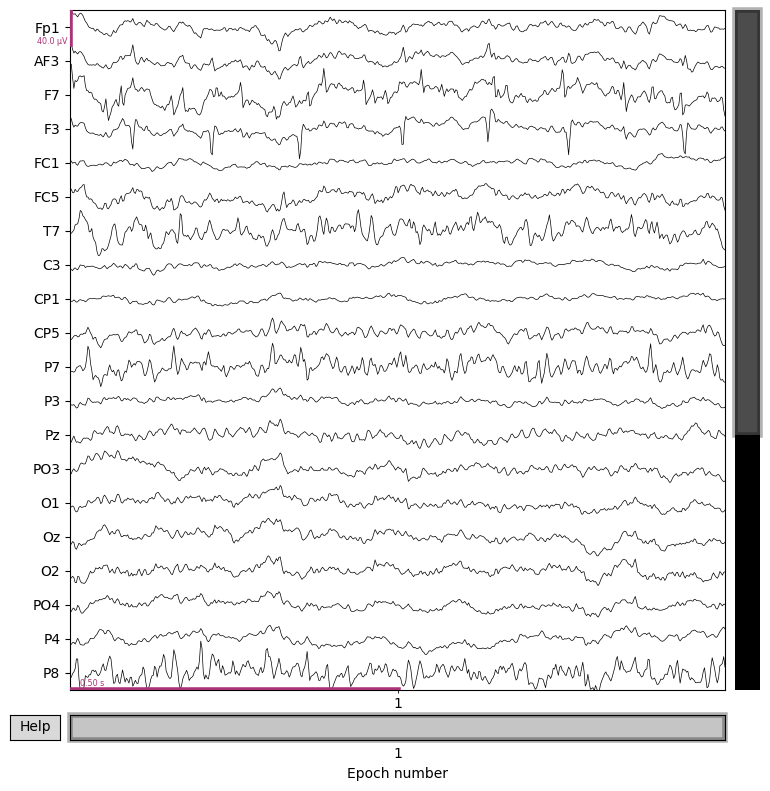

In [31]:
epochs_hc[0].plot()

In [32]:
print(epochs_hc.info)
print(len(epochs_hc))

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: True
 highpass: 0.5 Hz
 lowpass: 104.0 Hz
 meas_date: 2011-02-25 13:25:06 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
154


In [33]:
raw_pd = mne.io.read_raw_bdf('/Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf', preload=True)
raw_pd.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8',
                                  'Status']) #drop extra channels
raw_pd.set_eeg_reference(ref_channels='average')
raw_pd.filter(0.5, None, fir_design='firwin',phase='zero-double') #remove drifts

epochs_pd = mne.make_fixed_length_epochs(raw_pd, duration=1.0, preload=False, proj=True)
reject = get_rejection_threshold(epochs_pd)
print('The rejection dictionary is %s' % reject)
epochs_pd.drop_bad(reject=reject)

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)

Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


The rejection dictionary is {'eeg': 0.00016489478615330495}
Using data from preloaded Raw for 191 events and 512 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'T8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['T7', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'T8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'Fp2']
    Rejecting  ep

<Epochs | 77 events (all good), 0 – 0.998 s (baseline off), ~29 kB, data not loaded,
 '1': 77>

Using data from preloaded Raw for 1 events and 512 original time points ...


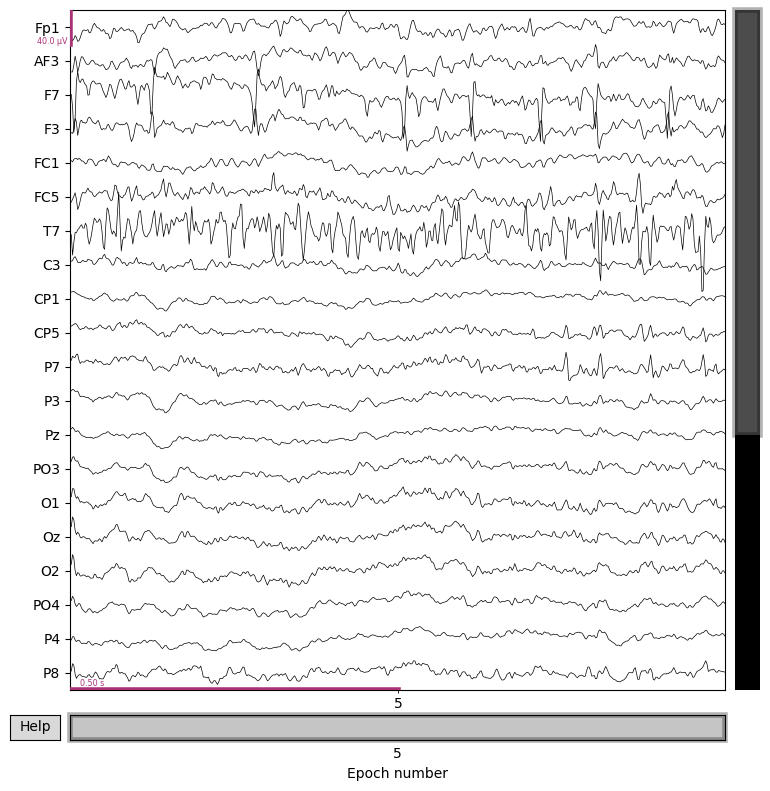

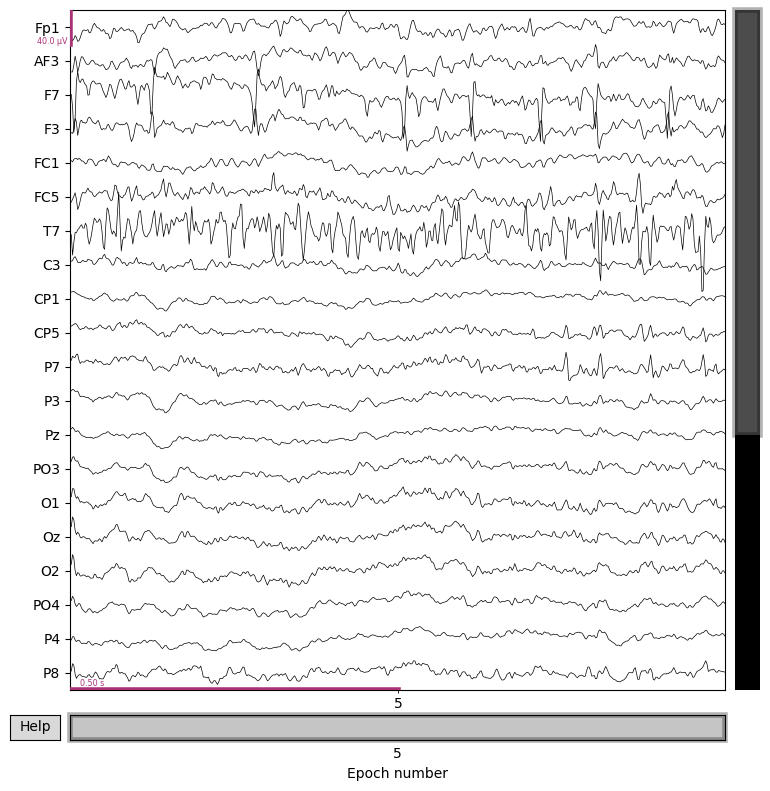

In [34]:
epochs_pd[0].plot()

In [35]:
print(epochs_pd.info)
print(len(epochs_pd))

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: True
 highpass: 0.5 Hz
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 13:07:18 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
77


In [ ]:
event_related_plot = epochs_pd.plot_image(picks=resp_channels)

KeyError: 'Event name "ch_names" could not be found. The following events are present in the data: 1'